In [1]:
!pip install pyreadstat
import pandas as pd
import pyreadstat as prs
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 2.4MB 4.1MB/s 


In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
#Load the data
df, meta = prs.read_sav("/content/drive/My Drive/Roy de Kleijn study data.sav")

In [4]:
#Extract the columns of the subject, independent variables, & dependent variable
df_3 = df.loc[(df["ExperimentList"]==3)][["Subject", "CategoryExp3", "Exp3FinalDecision"]]

#Create a dataframe
df_dict = {"Subject":[],"Category":[], "Decision":[]}

for n in df.Subject.unique():
  df_dict["Subject"].append(n)
  df_dict["Category"].append(df_3.loc[(df["Subject"] == n), ["CategoryExp3"]].iloc[0][0])
  df_dict["Decision"].append(df_3.loc[(df["Subject"] == n), ["Exp3FinalDecision"]].iloc[-1][0])

data = pd.DataFrame(data=df_dict, columns=df_dict.keys())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


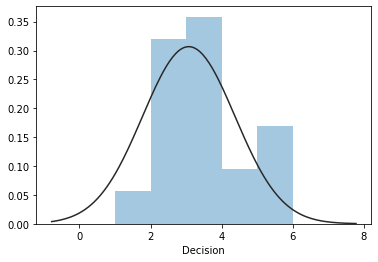

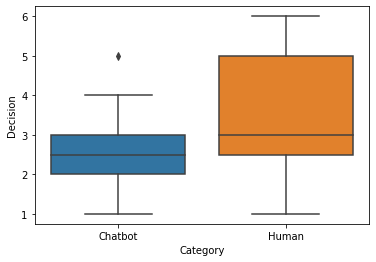

In [5]:
#Visualization of Data
def visualization(data, factor, target):

    #Distribution
    plt.figure()
    dist = sns.distplot(data[target], fit=norm, kde=False)
    #print(dist)

    #Box Plot
    plt.figure()
    box = sns.boxplot(x=factor, y=target, data=data)
    #print(box)

visualization(data, "Category", "Decision")

In [6]:
#One Way ANOVA Function (+ output table)

def one_way_anova(data, factor, target):

  #Calculate Means
  group_means = {}
  for n in data[factor].unique():
    group_means[n] = data.loc[(data[factor] == n), [target]][target].mean()
  
  grand_mean = data[target].mean()
  

  #Sum of Squares
  #SS Total
  ss_total = 0
  for n in data[target]:
    ss_total += (n-grand_mean)**2

  #SS Factor
  ss_factor = 0
  for n in group_means.keys():
    ss_factor += len(data.loc[(data[factor]==n)][factor])*(group_means[n]-grand_mean)**2

  #SS Within (Error)
  ss_within = 0
  for n in data[factor].unique():
    for m in data.loc[(data[factor] == n), [target]][target]:
      ss_within += (m-group_means[n])**2

  
  #Degrees of Freedom
  df_factor = len(data[factor].unique())-1
  df_within = len(data[target])-len(data[factor].unique())


  #Mean Squares
  ms_factor = ss_factor/df_factor
  ms_within = ss_within/df_within


  #F-Test
  F = ms_factor/ms_within


  #p-value
  p_value = stats.f.sf(F,df_factor,df_within,loc=0,scale=1)


  #result table
  results = {"SS":[ss_factor, ss_within, ss_total],
           "df":[df_factor, df_within, df_factor+df_within],
           "MS":[ms_factor, ms_within,""],
           "F":[F, "", ""],
            "P-Value":[p_value, "", ""]}
  columns=["SS", "df", "MS", "F", "P-Value"]
  result_table = pd.DataFrame(results, columns=columns, index = ["Factor", "Within", "Total"])
  output = print(f"Group means:{group_means}\n\nOne-Way ANOVA:\n{result_table}")

  return output

In [7]:
#Execute ANOVA
one_way_anova(data, "Category", "Decision")

Group means:{'Chatbot': 2.5384615384615383, 'Human': 3.5925925925925926}

One-Way ANOVA:
               SS  df       MS        F     P-Value
Factor  14.718056   1  14.7181  10.0109  0.00262297
Within  74.980057  51   1.4702                     
Total   89.698113  52                              


In [8]:
#Function to compare mean vs. factor model with cross-validation
def compare_models(X, Y, folds, repetitions):

  import numpy as np
  import pandas as pd
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import KFold
  
  #Prediction by Mean (to pass to sklearn cross-validation)
  class MeanPredictor():
    def __init__(self, mean=None):
      if mean is not None:
        self.mean =mean

      else:
        self.mean=None

    
    def fit(self, X, Y):
      self.mean = np.mean(Y)

    def predict(self, X):
      return np.full(X.shape[0], self.mean)

    def get_params(self, deep=False):
      return {"mean":self.mean}


  result_list = []
  win_count = 0

  #Creat dummy variable ("Chatbot" = 1; "Human" = 0) for Regression
  x = pd.get_dummies(X)

  #For every repetition run cross-validation with mean & factor model
  for n in range(repetitions):
    cv = KFold(n_splits=folds, shuffle=True, random_state=n)
    score1 = np.sqrt(cross_val_score(MeanPredictor(), x, Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1).mean()*-1)
    score2 = np.sqrt(cross_val_score(LinearRegression(), x, Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1).mean()*-1)

    #Count the winning model
    if score1 < score2:
      result_list.append([score1, 1, score2, 0])
      win_count += 1

    elif score1 > score2:
      result_list.append([score1, 0, score2, 1])
      win_count -=1

    else:
      result_list.append([score1, 1, score2, 1])

  #Print the winner (if there is one)
  if win_count > 0:
     print(f"Prediction by Mean wins in {win_count/repetitions*100}% of all repetitions!")

  elif win_count < 0:
    print(f"Factor Model wins in {win_count/repetitions*-100}% of all repetitions!")

  else:
    print("Models are even")
  
  #Create a dataframe of the RMSEs and the Wins for each model
  column_names = ["Prediction by Mean", "Win1", "Factor Model", "Win2"]
  df_list=pd.DataFrame(result_list, columns=column_names)
  df_list.index += 1 
  
  return df_list

In [9]:
#Run comparison function and store in “comparison” variable
comparison = compare_models(data.Category, data.Decision, 
                            folds=10, repetitions=100)

Factor Model wins in 100.0% of all repetitions!


AxesSubplot(0.125,0.125;0.775x0.755)


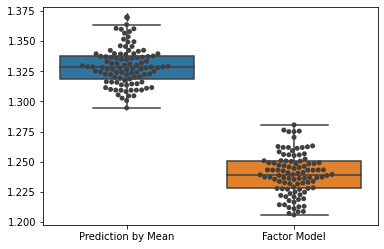

In [10]:
#Create box plot to compare RMSE of both models
def plot_rmse(df):

  plt.figure()
  box_df = df[["Prediction by Mean", "Factor Model"]]
  box = sns.boxplot(data = box_df)
  box = sns.swarmplot(data = box_df, color=".25")
  print(box)

plot_rmse(comparison)